In [186]:
# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv


from nb_functions import find_filtered_voronoi_neighbor_knn_limited_mask

In [187]:
# positions = np.load('quarters/positions.npy')
# print(positions.shape)

# # load data

# data = []
# for i in range(4):
#     for subpart in ["both", "BMP", "FGF"]:
#         dat = np.load(f"quarters/quarter_{i}_{subpart}_SMAD_and_ERK.npy")
#         dat = dat.swapaxes(1, 2)
#         data.append(dat)


# data = np.array(data)

positions = []

data = []

for i in range(4):
    positions.append(np.load(f"positions/random_{i}_positions.npy"))
    SMAD_ERK = np.load(f"positions/random_{i}_SMAD_and_ERK.npy")
    SMAD_ERK = SMAD_ERK.swapaxes(1, 2)

    SMAD_ERK[:,:,0] *= 100.
    print(SMAD_ERK.shape)
    data.append(SMAD_ERK)

(1001, 1000, 2)
(1001, 1000, 2)
(1001, 1000, 2)
(1001, 1000, 2)


TODO:

Get data from the actual system of interest

PINN!

Encoding?

Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [171]:
class CustomGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(CustomGNN, self).__init__()
        # check if list
        if type(hidden_dims) is not list:
            hidden_dims = [hidden_dims]
        
        # convolutional layer
        self.input_layer = GraphConv(input_dims, hidden_dims[0])

        self.hidden_layers = torch.nn.ModuleList()
        # Linear layers
        for i in range(len(hidden_dims)-1):
            _in = hidden_dims[i]
            _out = hidden_dims[i+1]

            self.hidden_layers.append(Linear(_in, _out))


        self.output_layer = Linear(hidden_dims[-1], output_dims)


    def forward(self, feature_data, edge_info, edge_weights):


        # First Graph Convolutional layer (message passing)
        x = self.input_layer(feature_data, edge_info, edge_weights)
        x = F.relu(x)


        # Second GCN layer
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)


        x = self.output_layer(x, )
        # x = self.layer3(x, edge_info, edge_weights)
        # x = torch.tanh(x)

        
        return x
    
    def get_weights(self):
        weights = []
        weights.append(self.input_layer.lin_rel.weight)
        weights.append(self.input_layer.lin_root.weight)

        for hl in self.hidden_layers:
            weights.append(hl.weight)
        weights.append(self.output_layer.weight)

        return weights
    
    

class Enviroment():
    def __init__(self):
        # load the data

        self.positions = positions

        self.ys = []       
        self.y_test = [] 

        
        self.edges = []
        self.edge_weights = []
        self.border_mask = []

        for d, pos in zip(data, self.positions):
            self.ys.append(torch.tensor(d, dtype=torch.float32))
            edge, edge_weights, border_mask = self.get_edges(pos)
            self.edges.append(edge)
            self.edge_weights.append(edge_weights)
            self.border_mask.append(border_mask)

        self.model = None
        self.optimizer = None

        self.early_stop_count = 0

        

    def loss_fn(self, out, target):
        base_loss = F.mse_loss(out, target)
        
        l1_weights = torch.mean(torch.stack([wh.abs().sum() for wh in self.model.get_weights()]))

        addition = 0.0001*l1_weights


        return base_loss + addition
    

    def get_edges(self, positions):

        # create a graph with 1000 nodes
        # create a KD tree for fast nearest neighbor search
        # tree = KDTree(positions)
        # dists, indices = tree.query(positions, k=10)

        # indices[dists > 4.5] = -1

        indices, dists = find_filtered_voronoi_neighbor_knn_limited_mask(positions, 8,)
        print(indices.shape, dists.shape)
        # create adjacency matrix
        adj_matrix = np.zeros((indices.shape[0], indices.shape[0]))
        for i in range(indices.shape[0]):
            for ji, j in enumerate(indices[i]):
                if j == -1:
                    continue
                adj_matrix[i, j] = dists[i, ji]
                adj_matrix[j, i] = dists[i, ji]

        # create edge data
        edges = torch.tensor(np.array(np.where(adj_matrix > 0)), dtype=torch.long).t().contiguous().T
        edge_weights = torch.tensor(adj_matrix[adj_matrix > 0], dtype=torch.float32)

        # make border array if less than 3 nbs
        border_mask = (adj_matrix>0.).sum(axis = 0) <= 4
        
        return edges, edge_weights, torch.tensor(border_mask)

    def set_model(self, model):

        # from intel_npu_acceleration_library.compiler import CompilerConfig
        # compiler_conf = CompilerConfig(dtype=torch.float32, training=True)
        # compiled_model = intel_npu_acceleration_library.compile(model, compiler_conf)
        self.model = model

        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def call_model(self, X, edges, edge_weights, border_mask):
        X = torch.cat((X, border_mask.unsqueeze(1)), dim = 1)
        
        return self.model(X, edges, edge_weights)


    

    def check_early_stop(self, avg_loss, test_loss):
        if test_loss < avg_loss:
            self.early_stop_count = 0
            return False

        if self.early_stop_count >= 3:
            return True
        
        self.early_stop_count += 1
        return False
        



    def train(self, epochs):
        assert self.model is not None, "Model is not initialized"

        # train the model
        self.model.train()
        for epoch in range(1,epochs+1):
            loss = torch.tensor(0.0)
            avg_loss = torch.tensor(0.0)
            for data_i in range(len(self.ys)):
                yy = self.ys[data_i]
                edges = self.edges[data_i]
                edge_weights = self.edge_weights[data_i]
                border_mask = self.border_mask[data_i]


                n_steps = yy.shape[0] - 800
                for i in range(n_steps):
                    X = yy[i]

                    target = yy[i + 10]

                    # X, target = self.transformation(X, target)

                    self.optimizer.zero_grad()


                    out = self.call_model(X, edges, edge_weights, border_mask)

                    loss = self.loss_fn(out, target) 

                    loss.backward()
                    self.optimizer.step()
                    avg_loss += loss.item()
            
            avg_loss /= n_steps

            avg_loss = avg_loss.item()

            if epoch % 5 == 0:
                print(epoch)
                print(f"{epoch/epochs:.3} loss:", avg_loss)
                # test_loss = self.test()
                # if self.check_early_stop(avg_loss, test_loss):
                    # print('Early stoppping')
                l1_weights = torch.sum(torch.tensor([F.mse_loss(wh, torch.zeros_like(wh)) for wh in self.model.get_weights()]))
                print(l1_weights.item())
                    # break

 




# create a GNN model
model = CustomGNN(3, [4], 2)

# create a training enviroment
env = Enviroment()

env.set_model(model)

env.train(1000)

(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 10) (1000, 10)
5
0.005 loss: 0.0022791167721152306
0.5260939598083496
10
0.01 loss: 0.0021697513293474913
0.5671993494033813
15
0.015 loss: 0.002161754760891199
0.6140351295471191
20
0.02 loss: 0.0021483576856553555
0.6454665660858154
25
0.025 loss: 0.0021627608221024275
0.6678372621536255
30
0.03 loss: 0.00216939696110785
0.6854162216186523
35
0.035 loss: 0.0021825514268130064
0.6901248693466187
40
0.04 loss: 0.002156684873625636
0.6952045559883118
45
0.045 loss: 0.0021651843562722206
0.6979753971099854
50
0.05 loss: 0.0021650923881679773
0.7037158012390137
55
0.055 loss: 0.0021671352442353964
0.7009053230285645
60
0.06 loss: 0.002185209421440959
0.7026705145835876
65
0.065 loss: 0.0021607764065265656
0.7024652361869812
70
0.07 loss: 0.0021740400698035955
0.7069383859634399
75
0.075 loss: 0.002178410766646266
0.7037122249603271
80
0.08 loss: 0.002171051688492298
0.7034652829170227
85
0.085 loss: 0.002172516891732812
0.

KeyboardInterrupt: 

C:\Users\jakob\AppData\Local\Temp\ipykernel_11284\1518210883.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(y_val[iii], dtype=torch.float32)
C:\Users\jakob\AppData\Local\Temp\ipykernel_11284\1518210883.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y_val[iii+10] , dtype=torch.float32)


(1000, 9) (1000, 9)
pos (1000, 2) torch.Size([1000, 2])


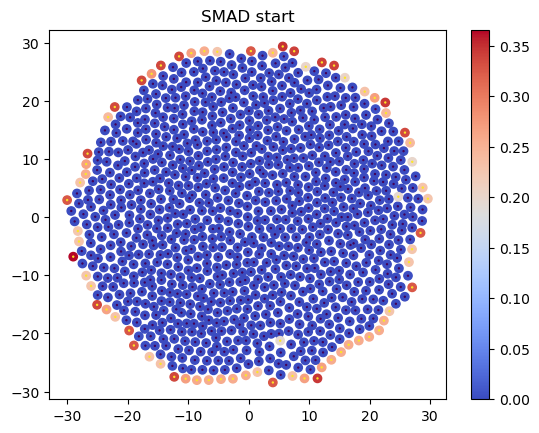

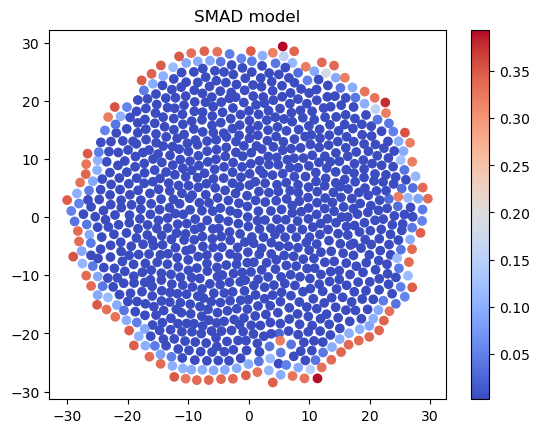

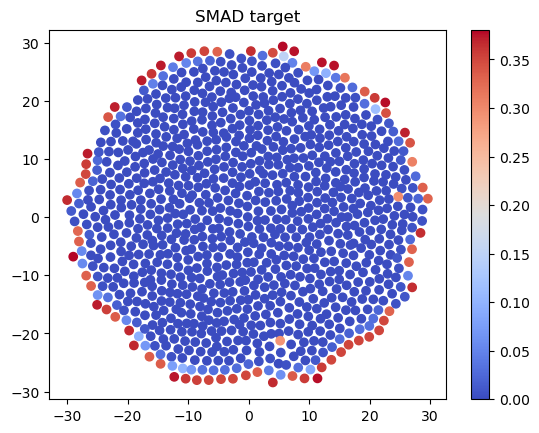

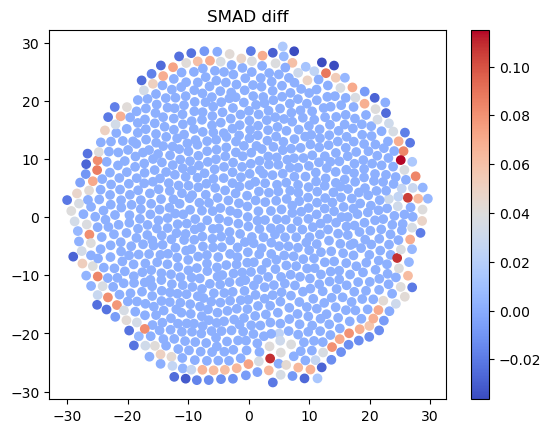

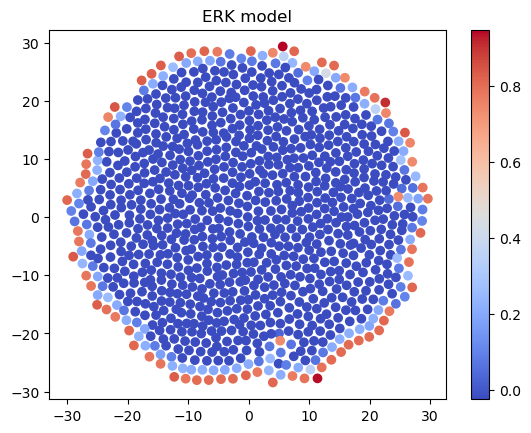

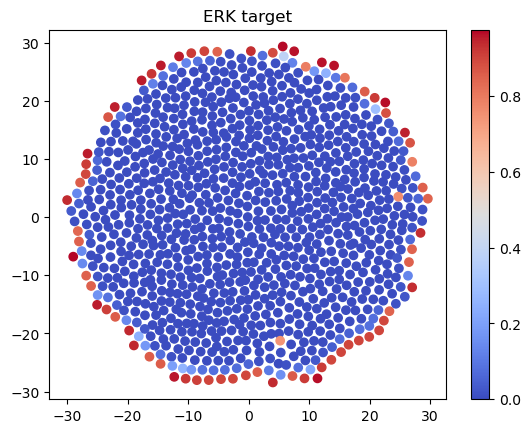

In [172]:
model.train(False)

# y_val = np.array([np.load(f'data/quarter_3_both.csv_BMP_levels.npy'), np.load(f'data/quarter_3_both.csv_FGF_levels.npy')])
y_val = env.ys[0]

poss = env.positions[0]

iii  = 10
X = torch.tensor(y_val[iii], dtype=torch.float32)
target = torch.tensor(y_val[iii+10] , dtype=torch.float32)

edges, edge_weights, border = env.get_edges(poss)

print("pos",poss.shape, X.shape)

# X = torch.cat((X, border.unsqueeze(1)), dim = 1)

out = env.call_model(X, edges, edge_weights, border)

out = out.detach().numpy()


plt.scatter(poss[:,0], poss[:,1], c=X[:,0], cmap='coolwarm')
plt.colorbar()
plt.scatter(poss[:,0], poss[:,1], c= env.border_mask[0], s= 0.5)
plt.title('SMAD start')
plt.show()

plt.scatter(poss[:,0], poss[:,1], c=out[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('SMAD model')
plt.show()


plt.scatter(poss[:,0], poss[:,1], c=target[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('SMAD target')
plt.show()

# plot diff

plt.scatter(poss[:,0], poss[:,1], c=(out[:,0] - target[:,0].detach().numpy()), cmap='coolwarm')
plt.colorbar()
plt.title('SMAD diff')
plt.show()



plt.scatter(poss[:,0], poss[:,1], c=out[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('ERK model')
plt.show()


plt.scatter(poss[:,0], poss[:,1], c=target[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('ERK target')
plt.show()



In [ ]:
parameters_to_prune = []

for layer in model.modules():
    if hasattr(layer, 'weight'):
        parameters_to_prune.append((layer, 'weight'))

from torch.nn.utils import prune
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

parameters_to_prune



[(Linear(3, 4, bias=True), 'weight'),
 (Linear(3, 4, bias=False), 'weight'),
 (Linear(4, 4, bias=True), 'weight'),
 (Linear(4, 2, bias=True), 'weight')]

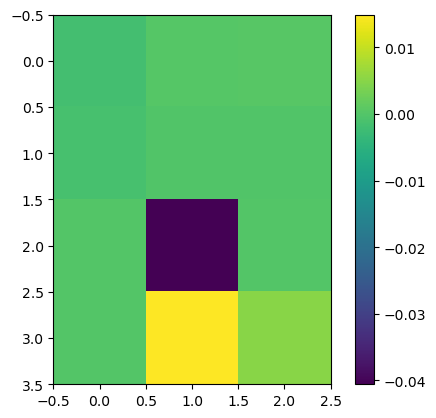

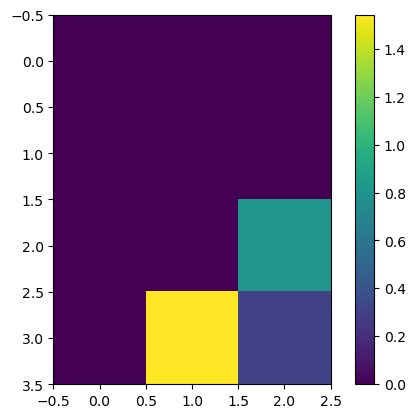

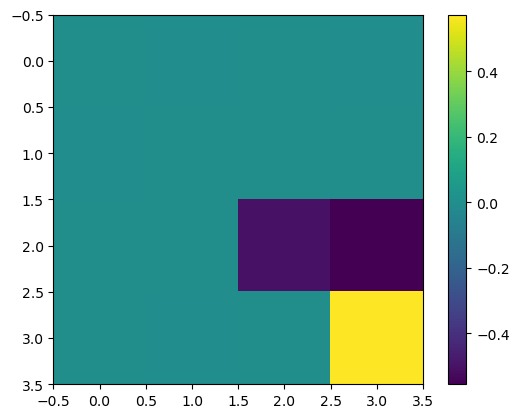

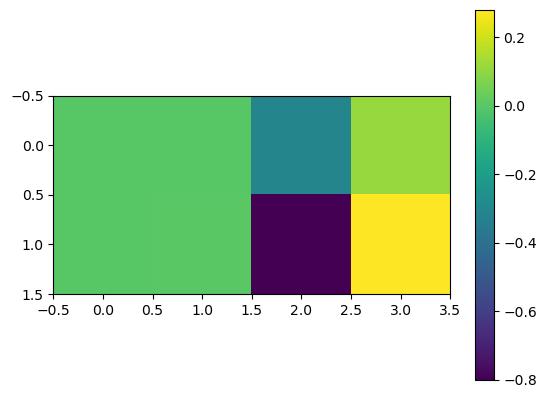

In [136]:

for weights in model.get_weights():

    w = weights.detach().numpy()
    plt.imshow(w)
    # mask = ~list(layer.named_buffers())[0][1].detach().numpy().astype(bool)
    # plt.scatter(np.where(mask)[1], np.where(mask)[0], c='r')
    plt.colorbar()
    plt.show()
    #print the bias

[3, 4, 2]


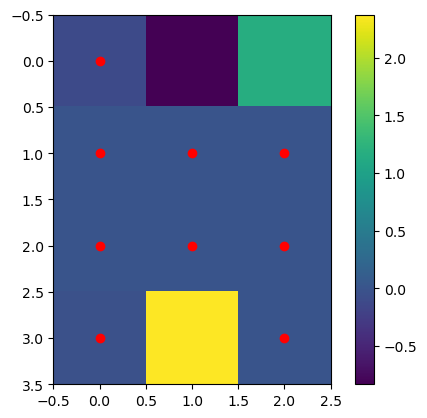

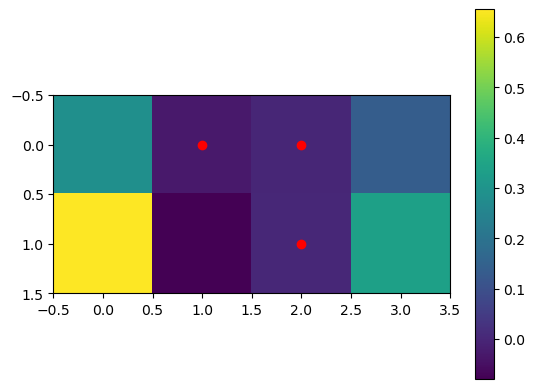

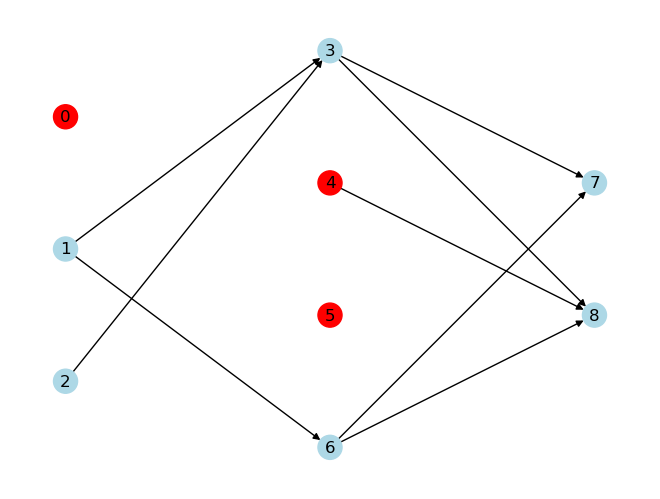

In [188]:
import networkx as nx

weights = [w.detach().numpy() for w in model.get_weights()][1:]


sizes = [w.shape[0] for w in weights]
sizes = [weights[0].shape[1]] + sizes

print(sizes)

G = nx.complete_multipartite_graph(*sizes)
pos = nx.multipartite_layout(G)

DG = G.to_directed()

# remove backwards edges
edges_to_remove = []
for edge in DG.edges(data=True):
    from_node_subset = DG.nodes(data=True)[edge[0]]['subset']
    to_node_subset = DG.nodes(data=True)[edge[1]]['subset']
    if (to_node_subset - from_node_subset) != 1:
        edges_to_remove.append(edge)
        
DG.remove_edges_from(edges_to_remove)

nodes_in_subsets = [[] for _ in range(len(sizes))]
for node in DG.nodes(data=True):
    subset = node[1]['subset']
    nodes_in_subsets[subset].append(node[0])

for weight_matrix_i in range(len(weights)):
    weight_matrix = weights[weight_matrix_i]
    # remove edges with small weights
    edges_to_remove = []
    mean_mag = np.mean(np.abs(weight_matrix))

    to_remove_mask = np.zeros_like(weight_matrix, dtype=bool)
    for i, w in enumerate(weight_matrix):
        mean_mag_row = np.mean(np.abs(w))
        for j, w_ in enumerate(w):
            if np.abs(w_) < 0.2*mean_mag or np.abs(w_) < 0.2*mean_mag_row:

                edges_to_remove.append((nodes_in_subsets[weight_matrix_i][j], nodes_in_subsets[weight_matrix_i+1][i], {}))
                to_remove_mask[i, j] = True

    DG.remove_edges_from(edges_to_remove)

    plt.imshow(weight_matrix)
    plt.colorbar()
    plt.scatter(np.where(to_remove_mask)[1], np.where(to_remove_mask)[0], c='r')
    plt.show()


# # remove nodes with no outgoing edges or incoming edges
node_colors = []
for node in DG.nodes(data=True):
    col = "lightblue"
    if len(list(DG.in_edges(node[0]))) == 0 and not node[1]['subset'] == 0:
        col = 'r'
    elif len(list(DG.out_edges(node[0]))) == 0 and not node[1]['subset'] == len(sizes)-1:
        col = 'r'

    node_colors.append(col)

# color the edges based on the weight matrix


nx.draw(DG, pos, with_labels=True, node_color=node_colors)
plt.show()

